## Model evaluation

In [1]:
using Flux
using Plots
using DataFrames
using Printf
using BSON, JSON
using Arrow
using StatsBase
using Unicode
using Random

In [2]:
using Revise
using TokenizersLite
using TransformersLite

In [3]:
includet("reporting.jl")
includet("training.jl")

In [4]:
nlabels = 5

5

## Load data

raw

In [5]:
path = "path\\to\\amazon_reviews_multi\\en\\1.0.0\\"
file_train = "amazon_reviews_multi-train.arrow"
file_test = "amazon_reviews_multi-test.arrow" ;

In [6]:
checksum = readdir(path)[1]
filepath = joinpath(path, checksum, file_train)
df = DataFrame(Arrow.Table(filepath))

checksum = readdir(path)[1]
filepath = joinpath(path, checksum, file_test)
df_test = DataFrame(Arrow.Table(filepath));

In [7]:
nrow(df)

200000

In [8]:
documents = df[:, "review_body"]
labels = df[:, "stars"]

println("training samples: ", size(documents), " ", size(labels))

training samples: (200000,) (200000,)


In [9]:
documents_test = df_test[:, "review_body"]
labels_test = df_test[:, "stars"];

println("test samples: ", size(documents_test), " ", size(labels_test))

test samples: (5000,) (5000,)


## Tokenizers

In [10]:
vocab_directory = "..\\vocab\\bpe"
path_rules = joinpath(vocab_directory, "amazon_reviews_train_en_rules.txt")
path_vocab = joinpath(vocab_directory, "amazon_reviews_train_en_vocab.txt")
vocab = load_vocab(path_vocab)

@show tokenizer = load_bpe(path_rules, startsym="⋅")
#@show tokenizer = load_affix_tokenizer(path_vocab)
@show indexer = IndexTokenizer(vocab, "[UNK]")

tokenizer = load_bpe(path_rules, startsym = "⋅") = BytePairEncoder{String}(length(rules)=8000, length(cache)=0, unksym=[UNK], startsym=⋅, symbols=["##a", "##b", "##c", "##d", "##e", "##f", "##g", "##h", "##i", "##j", "##k", "##l", "##m", "##n", "##o", "##p", "##q", "##r", "##s", "##t", "##u", "##v", "##w", "##x", "##y", "##z", "⋅a", "⋅b", "⋅c", "⋅d", "⋅e", "⋅f", "⋅g", "⋅h", "⋅i", "⋅j", "⋅k", "⋅l", "⋅m", "⋅n", "⋅o", "⋅p", "⋅q", "⋅r", "⋅s", "⋅t", "⋅u", "⋅v", "⋅w", "⋅x", "⋅y", "⋅z", ",", ".", "?", "!", ":", ";", "\$", "€", "£", "&"])
indexer = IndexTokenizer(vocab, "[UNK]") = IndexTokenizer{String}(length(vocabulary)=7455, unksym=[UNK])


IndexTokenizer{String}(length(vocabulary)=7455, unksym=[UNK])

In [11]:
function clean(s::AbstractString)
    s = lowercase(s)
    s = Unicode.normalize(s, :NFD)
    s = replace(s, r"['`’\u200d\p{M}]" => "") # contractions, zero width joiner and marks from normalization
    s = replace(s, r"\n" => " ")
end

function preprocess(document, tokenizer; pattern = r"[A-Za-z][A-Za-z]+\b", max_length::Union{Nothing, Int}=nothing)
    document = clean(document)
    words = map(m->string(m.match), eachmatch(pattern, document))
    tokens = tokenizer(words)
    if !isnothing(max_length)
        if length(tokens) > max_length
            tokens = tokens[1:max_length]
        end
    end
    tokens
end

preprocess (generic function with 1 method)

In [12]:
max_length = 50

@time tokens = map(d->preprocess(d, tokenizer, max_length=max_length), documents) #takes about 30 seconds for all documents
@time indices = indexer(tokens) #takes about 12 seconds for all documents

y_train = copy(labels)
idxs = Base.OneTo(length(labels))
X_train, y_train = indices[:, idxs], y_train[idxs];
y_train = Flux.onehotbatch(y_train, 1:nlabels) # multi-class
train_data, val_data = split_validation(X_train, y_train; rng=MersenneTwister(2718))

println("train samples:      ", size(train_data[1]), " ", size(train_data[2]))
println("validation samples: ", size(val_data[1]), " ", size(val_data[2]))

 42.053770 seconds (654.73 M allocations: 20.558 GiB, 9.10% gc time, 1.22% compilation time)
 17.226100 seconds (114.70 k allocations: 83.865 MiB, 0.14% gc time, 0.30% compilation time)
train samples:      (50, 180000) (5, 180000)
validation samples: (50, 20000) (5, 20000)


In [13]:
max_length = 50

y_test = copy(labels_test)
y_test = Flux.onehotbatch(y_test, 1:5);

@time tokens_test = map(d->preprocess(d, tokenizer, max_length=max_length), documents_test) 
@time indices_test = indexer(tokens_test)

X_test = indices_test

println("test indices: ", size(indices_test))
println("test samples: ", size(X_test), " ", size(y_test))

  0.535899 seconds (6.00 M allocations: 210.075 MiB, 6.48% gc time, 14.64% compilation time)
  0.405426 seconds (4 allocations: 1.946 MiB)
test indices: (50, 5000)
test samples: (50, 5000) (5, 5000)


## Evaluate

In [14]:
loss(x, y) = Flux.logitcrossentropy(model(x), y)
loss(x::Tuple) = loss(x[1], x[2])

loss (generic function with 2 methods)

In [15]:
add_position_encoding(x) = x .+ PositionEncoding(32)(x) 

add_position_encoding (generic function with 1 method)

In [16]:
directory = "../outputs/20220517_2006"

BSON.@load joinpath(directory, "model.bson") model
model

TransformerClassifier(
     Embed(32, 7455),                   # 238_560 parameters
     PositionEncoding(32),
     TransformerEncoderBlock(
          MultiheadAttention(num_heads=4, head_size=8, 32=>32)(
               denseQ = Dense(32 => 32),  # 1_056 parameters
               denseK = Dense(32 => 32),  # 1_056 parameters
               denseV = Dense(32 => 32),  # 1_056 parameters
               denseO = Dense(32 => 32),  # 1_056 parameters
          )
          LayerNorm(32),                # 64 parameters
          Dense(32 => 128, relu),       # 4_224 parameters
          Dense(128 => 32),             # 4_128 parameters
          LayerNorm(32),                # 64 parameters
     )     MeanLayer(),
     Dense(50 => 5),                    # 255 parameters
)                  # Total: 19 arrays, 251_519 parameters, 1.083 MiB.

In [17]:
@time batched_metric(accuracy, train_data[1], train_data[2], g=model)

 63.252852 seconds (33.28 M allocations: 55.640 GiB, 8.76% gc time, 19.15% compilation time)


0.5616500000000002

In [18]:
@time batched_metric(accuracy, val_data[1], val_data[2], g=model)

  5.241257 seconds (4.06 k allocations: 5.988 GiB, 9.07% gc time)


0.4996500000000001

In [19]:
history = Dict()
open(joinpath(directory, "history.json"), "r") do f
    global history
    history=JSON.parse(read(f, String))
end

Dict{String, Any} with 4 entries:
  "train_loss" => Any[1.21884, 1.15034, 1.12275, 1.09654, 1.09587, 1.06384, 1.0…
  "train_acc"  => Any[0.459517, 0.492639, 0.506722, 0.517856, 0.519294, 0.53552…
  "val_acc"    => Any[0.45355, 0.47845, 0.4897, 0.49925, 0.4958, 0.50095, 0.505…
  "val_loss"   => Any[1.23047, 1.17238, 1.1545, 1.14082, 1.15354, 1.13033, 1.12…

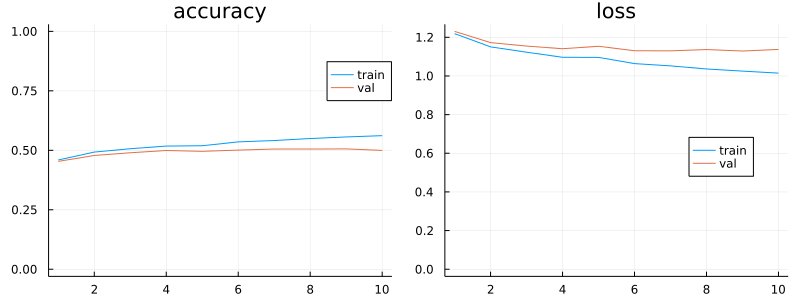

In [20]:
epochs = 1:length(history["train_acc"])
p1 = plot(epochs, history["train_acc"], label="train")
plot!(p1, epochs, history["val_acc"], label="val")
plot!(p1, ylims=[0, 1], title="accuracy", legend=(0.9, 0.8))

p2 = plot(epochs, history["train_loss"], label="train")
plot!(p2, epochs, history["val_loss"], label="val")
plot!(p2, title="loss", ylims=[0, Inf], legend=(0.8, 0.5))
plot(p1, p2, layout=grid(1, 2), size=(800, 300))

## Test data

In [21]:
logits = model(X_test)
@time accuracy(logits, y_test)

  0.000199 seconds (14 allocations: 181.031 KiB)


0.5054

In [22]:
probs = softmax(logits, dims=1)
y_pred = Flux.onecold(probs);

In [23]:
cm = confusion_matrix(vec(y_pred), Flux.onecold(y_test), 1:nlabels)

5×5 Matrix{Int64}:
 651  211   82   20   36
 262  365  260   81   32
 122  220  405  188   65
  23   67  253  383  274
  23   23   50  181  723

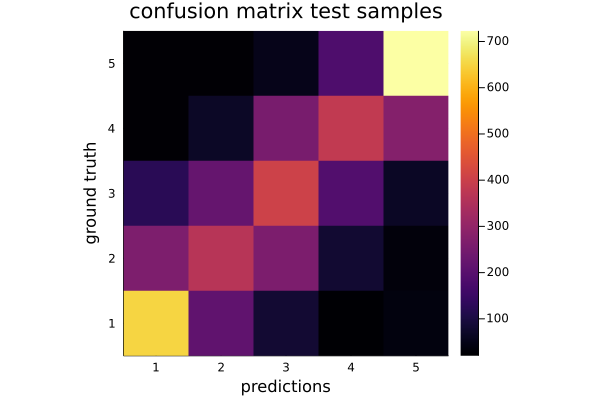

In [24]:
p = heatmap(1:5, 1:5, cm, xlabel="predictions", ylabel="ground truth", xlims=(0.5, nlabels+0.5), aspectratio=1,
    title="confusion matrix test samples", xticks=(1:5)) #, ["negative", "mix", "positive"]))
#savefig(p, "../outputs/confusion_matrix_classification$(nlabels).png")
p

In [25]:
classification_report(cm, 1:nlabels)

              precision  recall  f1-score  support
           1       0.60    0.65      0.63     1000
           2       0.41    0.36      0.39     1000
           3       0.39    0.41      0.40     1000
           4       0.45    0.38      0.41     1000
           5       0.64    0.72      0.68     1000

weighted avg       0.50    0.51      0.50     5000

In [26]:
nshow = 2

for label in 1:nlabels
    println("\ntrue label = $label")
    idxs = labels_test .== label
    idxs_label = (1:length(labels_test))[vec(idxs)]
    idxs_wrong = idxs_label[y_pred[idxs] .!== label]
    println("#incorrect $(length(idxs_wrong))")
    for idx in sample(idxs_wrong, nshow, replace=false)
        println("$idx-$(labels_test[idx])-$(y_pred[idx]) - ", documents_test[idx])
    end
end


true label = 1
#incorrect 349
764-1-2 - Broke, started to tear immediately when pulling weight
121-1-2 - The comforter is super hot but washed the first time and the fabric ripped. Super cheap quality.

true label = 2
#incorrect 635
1553-2-1 - Had I know that this item was this small I would never have paid more than $5.00 for this product. I could’ve gotten these at Target for half the price I paid. What a waste!
1641-2-4 - Gets linty quick it's more of q cotton martial

true label = 3
#incorrect 595
2856-3-1 - The pendant is lovely but the clasp is faulty and I can't even open it to put the pendant on the chain. It is bent or jammed or something. There is no way to contact the seller so I guess I'll have to return it.
2185-3-2 - These bags are so easy, I love them! My ONLY problem is the measurements are way off! I took one bag and marked it correctly as a reference. If it wasn't for that they would be a 5 star. I've gone through almost 35 now and not one has leaked.

true label = 4

## Probabilities for all labels

In [27]:
for star in nlabels:-1:1
    pos_max = argmax(probs[star, :])
    println(star, " - ", labels_test[pos_max], " - ", y_pred[pos_max], " - ", 
        probs[star, pos_max], " - ", documents_test[pos_max])
end

5 - 5 - 5 - 0.9836584 - Best toys ever for Jack Russells! They cant destroy them! Love Kong Toys!
4 - 4 - 4 - 0.7941871 - Great product. Only complaint I have was in packaging some paints did leak. Otherwise excellent!
3 - 2 - 3 - 0.8007779 - These are wonderful poles tall durable the cap is nice on the top, reflective tape is good. The only downside that is disappointing is I bought the yellow ones and within a month they are compleatly faded. I was using them in the summer to mark areas on a field. Now they are almost white which makes them very hard to see, kind of defeats the purpose of buying nice visible poles.
2 - 2 - 2 - 0.64235765 - What I like the most is the easy clean up ... nothing sticks! What I like the least is that only two of the pans will work on my induction cooker. Neither small sauce pan nor the small skillet are recognizable to the cooker causing a no pan error code.
1 - 1 - 1 - 0.9564968 - I never received this order,I need a refund or the product


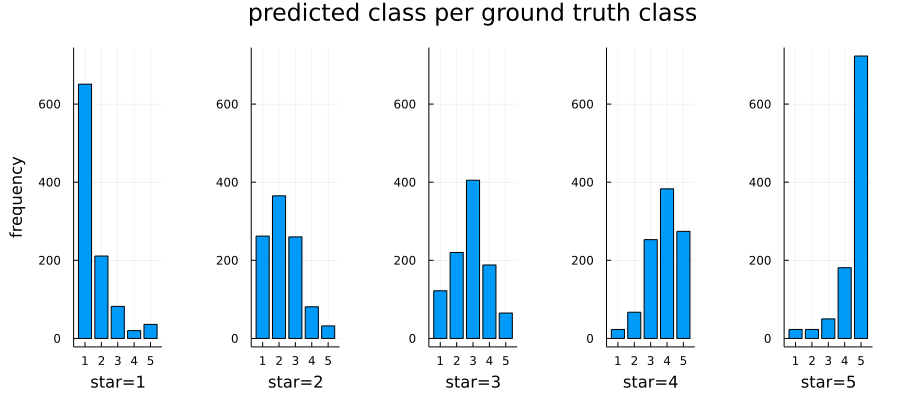

In [28]:
canvases = []
label_names = 1:5
for gt_star in 1:5
    idxs = labels_test .== gt_star
    value_counts = [sum((y_pred[idxs]) .== l) for l in 1:nlabels]
    p = bar(value_counts, xlabel="star=$gt_star",legend=:none, xticks=(1:nlabels, 1:5))#["neg", "mix", "pos"]))
    push!(canvases, p)
end
plot!(canvases[1], ylabel="frequency")
p =plot(canvases..., layout=(1, 5), link=:y, size=(900, 400), plot_title="predicted class per ground truth class",
    margin=5Plots.mm)
#savefig(p, "../outputs/predictions_classification$nlabels.png")
p

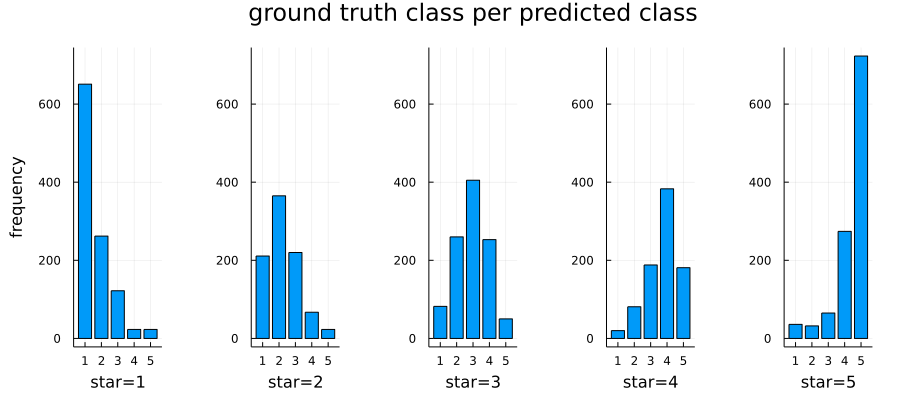

In [29]:
canvases = []
label_names = 1:5
for pred_star in 1:5
    idxs = y_pred .== pred_star
    value_counts = [sum((labels_test[idxs]) .== l) for l in 1:nlabels]
    p = bar(value_counts, xlabel="star=$pred_star",legend=:none, xticks=(1:nlabels, 1:5))#["neg", "mix", "pos"]))
    push!(canvases, p)
end
plot!(canvases[1], ylabel="frequency")
p =plot(canvases..., layout=(1, 5), link=:y, size=(900, 400), plot_title="ground truth class per predicted class",
    margin=5Plots.mm)
#savefig(p, "../outputs/predictions_classification$nlabels.png")
p

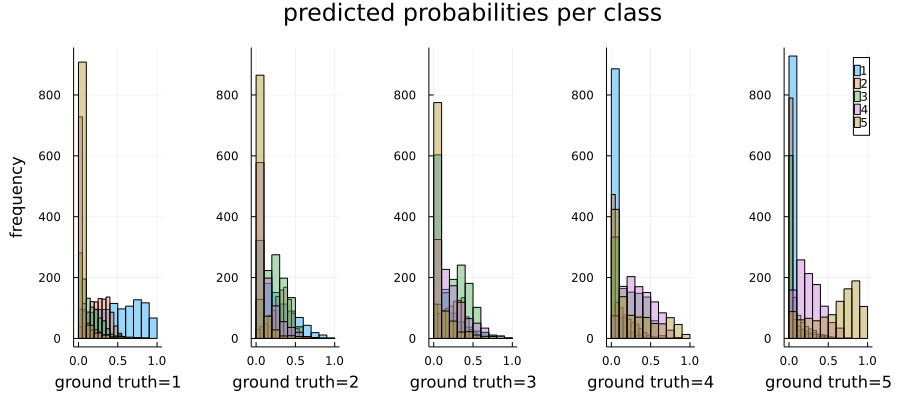

In [30]:
canvases = []
label_names = 1:5
for groundtruth_star in 1:5
    idxs = labels_test .== groundtruth_star
    probs_star = probs[:, idxs]
    p = plot(xlabel="ground truth=$groundtruth_star", legend=:none, xticks=([0.00, 0.50, 1.00]))
    for pred_star in 1:nlabels
        histogram!(probs_star[pred_star, :], fillalpha=0.4, label=label_names[pred_star], nbins=12)
    end
    push!(canvases, p)
end
plot!(canvases[1], ylabel="frequency")
plot!(canvases[5], legend=:best)
p =plot(canvases..., layout=(1, 5), link=:y, size=(900, 400), plot_title="predicted probabilities per class",
    margin=5Plots.mm)
#savefig(p, "outputs/probabilities_classification$nlabels.png")
p

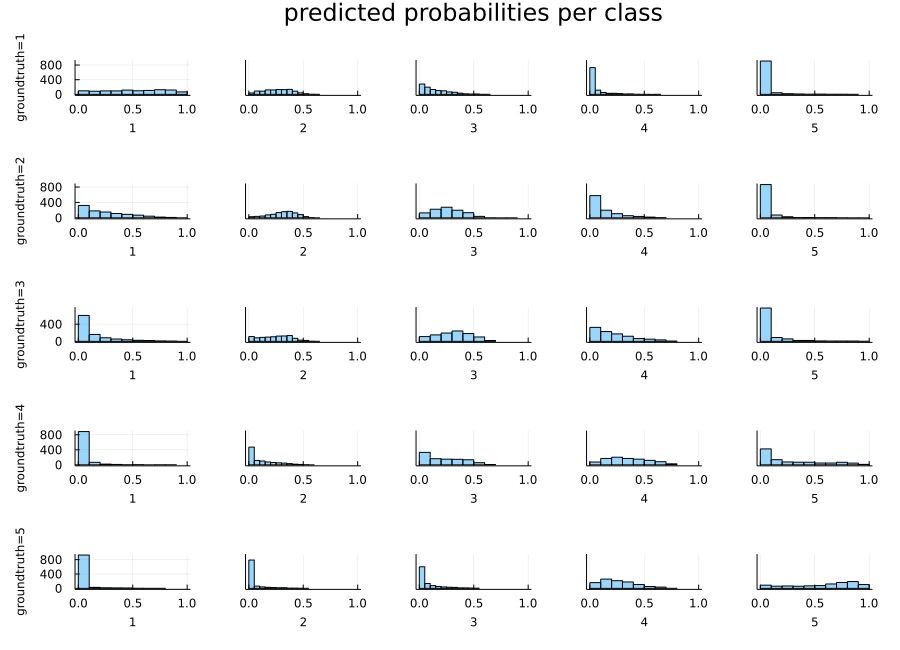

In [31]:
canvases = []
label_names = 1:5
for groundtruth_star in 1:5
    idxs = labels_test .== groundtruth_star
    probs_star = probs[:, idxs]
    #p = plot(xlabel="ground truth=$groundtruth_star", legend=:none, xticks=([0.00, 0.50, 1.00]))
    for pred_star in 1:nlabels
        p = histogram(probs_star[pred_star, :], fillalpha=0.4, label="", nbins=12,  
            xlims=[0, 1], xticks=([0.00, 0.50, 1.00]), yticks=([]), xlabel="$pred_star", xguidefontsize=8)
        push!(canvases, p)
    end
end

for groundtruth_star in 1:5
    plot!(canvases[1 + 5 * (groundtruth_star - 1)], ylabel="groundtruth=$groundtruth_star", yguidefontsize=8,
        yticks=([0, 400, 800])
    )
end
    
#plot!(canvases[1], ylabel="frequency")
#plot!(canvases[5], legend=:best)
p =plot(canvases..., layout=(5, 5), link=:y, size=(900, 650), plot_title="predicted probabilities per class",
    margin=5Plots.mm)
#savefig(p, "outputs/probabilities_classification$nlabels.png")
p

## Single sample

In [32]:
idx = 4600 

d = documents_test[idx]
println(labels_test[idx])
println(d)
tokens = preprocess(d, tokenizer, max_length=50)
println(join(tokens, "|"))
x = indexer(tokens)
x = vcat(x, ones(Int, 50 - length(x)))
println(join(x, "|"))

5
I used for a party and was great !
⋅used|⋅for|⋅party|⋅and|⋅was|⋅great
89|7|805|4|14|29|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1


In [33]:
model.embed(x)

32×50 Matrix{Float32}:
  0.944489    0.470819     2.59829    …  -0.436191  -0.436191  -0.436191
 -0.430363   -0.636429     0.493068      -0.743582  -0.743582  -0.743582
  1.11947     0.236173    -0.233785       1.30782    1.30782    1.30782
  0.276039   -0.869705    -0.201477      -0.159385  -0.159385  -0.159385
 -0.614896   -1.16134     -0.517375      -1.06883   -1.06883   -1.06883
  1.60492    -0.243058     0.0836509  …   0.10972    0.10972    0.10972
 -0.768734    0.463505    -2.32877       -0.289707  -0.289707  -0.289707
 -0.296231   -0.598664     1.51456       -0.309179  -0.309179  -0.309179
  1.30867     0.539524     0.966115       0.800112   0.800112   0.800112
 -1.0918      0.0435852   -2.19599        0.823499   0.823499   0.823499
 -1.10446     0.553012     0.578308   …   0.887524   0.887524   0.887524
 -0.898941   -0.167103     1.49044       -0.441624  -0.441624  -0.441624
  0.881497   -1.66737     -2.77597        0.288462   0.288462   0.288462
  ⋮                            

In [34]:
softmax(model(x))

5×1 Matrix{Float32}:
 0.0017646063
 0.0033964957
 0.01642579
 0.24962479
 0.72878826